### 图神经网络环境配置，参见 https://www.bilibili.com/video/BV1184y1x71H?p=11

In [1]:
import os
import numpy as np
import pandas as pd
import os
import pandas as pd
from scipy.io import loadmat
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import InMemoryDataset, Data
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from torch_geometric.nn import TopKPooling,SAGEConv, GCNConv, SAGPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as  gmp
from torch.nn import Linear,BatchNorm1d, ReLU
import torch.nn.functional as F
from imblearn.under_sampling import RandomUnderSampler

device = torch.device("mps" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 参数

In [2]:
epoch_num = 30  # 训练轮数
lr = 0.001      # 学习率
bs = 64         # 批次大小
isCause = False # 是否加入因果关系

dataset_root = '../Data' # 数据存放目录

## 因果关系的加入
注意：节点必须从0开始标号

In [3]:
def get_edge_index_and_edge_attr(ex_type):
    # source_nodes->target_nodes对应着一条有向边，而edge_attr为此条有向边的权值,无向图代表两个方向都有边
    source_nodes = [0, 1, 0, 4, 0, 7, 1, 2, 2, 3, 4, 5, 5, 6, 7, 8, 8, 9, 8, 14, 8, 19, 9, 10, 10, 11, 11, 12, 12, 13, 14, 15, 15, 16, 16, 17, 17, 18, 19, 20, 20, 21]
    target_nodes = [1, 0, 4, 0, 7, 0, 2, 1, 3, 2, 5, 4, 6, 5, 8, 7, 9, 8, 14, 8, 19, 8, 10, 9, 11, 10, 12, 11, 13, 12, 15, 14, 16, 15, 17, 16, 18, 17, 20, 19, 21, 20]
    edge_attr = None
    if isCause:
        # # one leg stand
        # if ex_type == 1:
        #     source_nodes = [0, 1, 2, 4, 6, 7, 8, 8 , 8 , 9, 10, 11, 12, 15, 15, 16, 17, 19, 19, 21]
        #     target_nodes = [4, 0, 3, 5, 5, 0, 7, 9, 14, 10, 11, 12, 13, 14, 16, 17, 18, 8 , 20, 20]
        #     edge_attr = None
        if ex_type == 2:
            source_nodes = [0, 1, 2, 4, 6, 7, 8, 8 , 8 , 9, 10, 11, 12, 15, 15, 16, 17, 19, 19, 21]
            target_nodes = [4, 0, 3, 5, 5, 0, 7, 9, 14, 10, 11, 12, 13, 14, 16, 17, 18, 8 , 20, 20]
            edge_attr = None
    edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
    return edge_index, edge_attr

## 数据处理部分
注意：如果图结构发生改变，请删除数据根目录/processed/下的缓存文件，以重新进行数据处理

In [4]:
# 这个类继承自InMemoryDataset，专门处理中小型数据集
class BinaryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    # 如果根目录下的processed文件夹下已经尤处理好的图数据，则直接读取
    @property
    def processed_file_names(self):
        if isCause:
            return ['cause.dataset']
        else:
            return ['base.dataset',]
    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        """
        Load Data Seperate All data in Protective and Non-Prtective Data
        """
        # Assuming the 'Data' folder is in the current working directory
        data_folders = [dataset_root]

        # Initialize lists to store the separated dataframes
        protective_dfs = []
        non_protective_dfs = []

        # Loop through each data folder
        for data_folder in data_folders:
            # List all .mat files in the current data folder
            mat_files = [f for f in os.listdir(data_folder) if f.endswith('.mat')]
            # Load each mat file
            for mat_file in mat_files:
                # Construct the full path to the .mat file
                mat_path = os.path.join(data_folder, mat_file)
                # Load the .mat file
                mat_data = loadmat(mat_path)
                # Convert the data into a pandas dataframe
                df = pd.DataFrame(mat_data['data'])
                # Select only the first 70 columns and the last column (73rd) which contains the behavior label
                df = df.iloc[:, list(range(66)) + [70] + [72]]
                # Split the data based on the protective behavior label
                # Assuming the last column in df is the protective behavior label
                protective_behavior = df.iloc[:, -1]
                protective_df = df[protective_behavior == 1]
                non_protective_df = df[protective_behavior == 0]
                # Append the resulting dataframes to their respective lists
                protective_dfs.append(protective_df)
                non_protective_dfs.append(non_protective_df)

        # Concatenate all protective and non-protective dataframes
        all_protective_data = pd.concat(protective_dfs, axis=0, ignore_index=True)
        all_non_protective_data = pd.concat(non_protective_dfs, axis=0, ignore_index=True)

        # Now `all_protective_data` and `all_non_protective_data` hold the protective and non-protective data respectively
        # You can process these dataframes as needed for your analysis or save them to new .mat files
        # 保护和非保护数据个数 (77298, 68) (437247, 68)
        # 数据合并
        all_data = np.concatenate([all_protective_data,all_non_protective_data],axis=0)
        # 提取运动类型和保护性行为列
        ys = all_data[:,-2:]
        # 将特征列构建为N*V*C的形式，其中N=图个数（一条数据就可以看作一个图），V代表节点个数， C代表每个节点的特征个数
        x = all_data[:,np.newaxis,[0,22,44]]
        for node in range(2, 23):
            x_index = node - 1
            y_index = x_index + 22
            z_index = x_index + 44
            temp = all_data[:,np.newaxis,[x_index,y_index,z_index]]
            x = np.concatenate([x,temp], axis=1)
        # 将边整理为GNN要求的格式，边索引必须从0开始
       
        # 构建数据列表
        data_list = []
        # 一条数据构建为一个图
        for i in range(x.shape[0]):
            y = torch.tensor([ys[i,-1]], dtype=torch.float)   
            # 根据数据所属运动类型获得其拓扑结构
            edge_index, edge_attr = get_edge_index_and_edge_attr(ys[i,-2])
            if ys[i,-2] == 2:
                data = Data(x=torch.tensor(x[i], dtype=torch.float), edge_index=edge_index, edge_attr=edge_attr, y=y)
                data_list.append(data)
        # 将处理后的数据存储至指定根目录下
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
            
        
# 加载并分割数据集      
def load_data_and_split(dataset_root):
    # 数据打乱
    dataset = BinaryDataset(root=dataset_root)
    # 随机打乱
    dataset = dataset.shuffle()
    # 数据划分逻辑
    num_graphs = len(dataset)
    train_size = int(num_graphs * 0.8)
    # train_size = int(num_graphs * 0.01)
    
    # 创建训练集和测试集的子集索引
    train_indices = list(range(train_size))
    test_indices = list(range(train_size, num_graphs))
    
    # 使用torch_geometric.data.Subset来划分数据
    train_dataset = dataset.index_select(train_indices)
    test_dataset = dataset.index_select(test_indices)
    print("isCause:",isCause)
    print("len of train_dataset:",len(train_dataset))
    print("len of test_dataset :",len(test_dataset))
    # 创建DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
    
    return train_loader, test_loader

train_loader, test_loader =  load_data_and_split(dataset_root)

Processing...


isCause: False
len of train_dataset: 17884
len of test_dataset : 4471


Done!


## 模型定义
模块参见文档 https://pytorch-geometric.readthedocs.io/en/latest/

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = GCNConv(3,64)
        self.pool1 = TopKPooling(64, ratio=0.8)
        self.conv2 = GCNConv(64,64)
        self.pool2 = TopKPooling(64, ratio=0.8)
        self.conv3 = GCNConv(64,64)
        self.pool3 = TopKPooling(64, ratio=0.8)
        self.lin1 = Linear(64,64)
        self.lin2 = Linear(64,32)
        self.lin3 = Linear(32,1)
        # self.bn1 = BatchNorm1d(64)
        # self.bn2 = BatchNorm1d(32)
        self.act1 = ReLU()
        self.act2 = ReLU()

    
    def forward(self, data):
        x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

        x = x.clone().detach().requires_grad_(True)
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        # x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, edge_attr, batch)
        x1 = gap(x, batch)
        
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, edge_attr, batch)
        x2 = gap(x, batch)
        
        # x = F.relu(self.conv3(x, edge_index))
        # x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        # x3 = gap(x, batch)  
        
        x = x1 + x2
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # 输出值为0-1之间 （0为非保护 1为保护）
        x = torch.sigmoid(self.lin3(x)).squeeze(1)
        return x     

## 模型训练和测试

In [6]:
def train(train_loader):
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output, label)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():  # 在评估模式下不计算梯度
        for data in loader:
            data = data.to(device)
            out = model(data)  # 前向传播
            pred = (out >= 0.5).int()

            y_true.extend(data.y.clone().detach().tolist())  # 收集真实标签
            y_pred.extend(pred.clone().detach().tolist())  # 收集预测标签
    
    accuracy = accuracy_score(y_true, y_pred)
    macro_precision = precision_score(y_true, y_pred,  pos_label=1, average='macro') 
    
    f1 = f1_score(y_true, y_pred, pos_label=1)  # Only report results for the class specified by pos_label. 考虑了非平衡
    recall = recall_score(y_true, y_pred, pos_label=1)
    return accuracy, macro_precision, f1, recall

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
crit = torch.nn.BCELoss()
for epoch in range(1, epoch_num):
    train(train_loader)
    train_accuracy, train_macro_precision, train_f1, train_recall = test(train_loader)
    test_accuracy,  test_macro_precision,  test_f1 , test_recall  = test(test_loader)
    
    print(f'Epoch: {epoch:03d}  -------------------------- '
          f'\nTrain: accuracy: {train_accuracy:.4f}, Macro Precision: {train_macro_precision:.4f}, F1: {train_f1:.4f}, recall: {train_recall:.4f}  '
          f'\nTest : accuracy: {test_accuracy:.4f}, Macro Precision: {test_macro_precision:.4f}, F1: {test_f1:.4f}, recall: {test_recall:.4f}')

Epoch: 001  -------------------------- 
Train: accuracy: 0.7327, Macro Precision: 0.7465, F1: 0.5642, recall: 0.4447  
Test : accuracy: 0.7356, Macro Precision: 0.7427, F1: 0.5616, recall: 0.4469
Epoch: 002  -------------------------- 
Train: accuracy: 0.7471, Macro Precision: 0.7468, F1: 0.6199, recall: 0.5302  
Test : accuracy: 0.7466, Macro Precision: 0.7411, F1: 0.6119, recall: 0.5272
Epoch: 003  -------------------------- 
Train: accuracy: 0.7933, Macro Precision: 0.7939, F1: 0.7038, recall: 0.6311  
Test : accuracy: 0.7860, Macro Precision: 0.7827, F1: 0.6849, recall: 0.6139
Epoch: 004  -------------------------- 
Train: accuracy: 0.7960, Macro Precision: 0.7870, F1: 0.7295, recall: 0.7071  
Test : accuracy: 0.7913, Macro Precision: 0.7793, F1: 0.7177, recall: 0.7001
Epoch: 005  -------------------------- 
Train: accuracy: 0.8103, Macro Precision: 0.8237, F1: 0.7171, recall: 0.6180  
Test : accuracy: 0.8128, Macro Precision: 0.8267, F1: 0.7109, recall: 0.6074
Epoch: 006  --------

Epoch: 001  -------------------------- 
Train: accuracy: 0.7327, Macro Precision: 0.7465, F1: 0.5642, recall: 0.4447  
Test : accuracy: 0.7356, Macro Precision: 0.7427, F1: 0.5616, recall: 0.4469
Epoch: 002  -------------------------- 
Train: accuracy: 0.7471, Macro Precision: 0.7468, F1: 0.6199, recall: 0.5302  
Test : accuracy: 0.7466, Macro Precision: 0.7411, F1: 0.6119, recall: 0.5272
Epoch: 003  -------------------------- 
Train: accuracy: 0.7933, Macro Precision: 0.7939, F1: 0.7038, recall: 0.6311  
Test : accuracy: 0.7860, Macro Precision: 0.7827, F1: 0.6849, recall: 0.6139
Epoch: 004  -------------------------- 
Train: accuracy: 0.7960, Macro Precision: 0.7870, F1: 0.7295, recall: 0.7071  
Test : accuracy: 0.7913, Macro Precision: 0.7793, F1: 0.7177, recall: 0.7001
Epoch: 005  -------------------------- 
Train: accuracy: 0.8103, Macro Precision: 0.8237, F1: 0.7171, recall: 0.6180  
Test : accuracy: 0.8128, Macro Precision: 0.8267, F1: 0.7109, recall: 0.6074
Epoch: 006  -------------------------- 
Train: accuracy: 0.8286, Macro Precision: 0.8486, F1: 0.7426, recall: 0.6354  
Test : accuracy: 0.8278, Macro Precision: 0.8499, F1: 0.7308, recall: 0.6169
Epoch: 007  -------------------------- 
Train: accuracy: 0.8287, Macro Precision: 0.8288, F1: 0.7622, recall: 0.7054  
Test : accuracy: 0.8318, Macro Precision: 0.8307, F1: 0.7599, recall: 0.7025
Epoch: 008  -------------------------- 
Train: accuracy: 0.8222, Macro Precision: 0.8332, F1: 0.7396, recall: 0.6489  
Test : accuracy: 0.8244, Macro Precision: 0.8348, F1: 0.7349, recall: 0.6423
Epoch: 009  -------------------------- 
Train: accuracy: 0.8348, Macro Precision: 0.8434, F1: 0.7625, recall: 0.6814  
Test : accuracy: 0.8347, Macro Precision: 0.8420, F1: 0.7554, recall: 0.6736
Epoch: 010  -------------------------- 
Train: accuracy: 0.8128, Macro Precision: 0.8503, F1: 0.7020, recall: 0.5667  
Test : accuracy: 0.8170, Macro Precision: 0.8563, F1: 0.6988, recall: 0.5602
Epoch: 011  -------------------------- 
Train: accuracy: 0.8259, Macro Precision: 0.8697, F1: 0.7221, recall: 0.5812  
Test : accuracy: 0.8258, Macro Precision: 0.8714, F1: 0.7116, recall: 0.5673
Epoch: 012  -------------------------- 
Train: accuracy: 0.8395, Macro Precision: 0.8318, F1: 0.7917, recall: 0.7841  
Test : accuracy: 0.8327, Macro Precision: 0.8229, F1: 0.7771, recall: 0.7698
Epoch: 013  -------------------------- 
Train: accuracy: 0.8456, Macro Precision: 0.8448, F1: 0.7891, recall: 0.7425  
Test : accuracy: 0.8432, Macro Precision: 0.8416, F1: 0.7787, recall: 0.7279
Epoch: 014  -------------------------- 
Train: accuracy: 0.8300, Macro Precision: 0.8358, F1: 0.7574, recall: 0.6822  
Test : accuracy: 0.8349, Macro Precision: 0.8418, F1: 0.7561, recall: 0.6753
Epoch: 015  -------------------------- 
Train: accuracy: 0.8543, Macro Precision: 0.8692, F1: 0.7883, recall: 0.6975  
Test : accuracy: 0.8548, Macro Precision: 0.8727, F1: 0.7805, recall: 0.6812
Epoch: 016  -------------------------- 
Train: accuracy: 0.8564, Macro Precision: 0.8695, F1: 0.7928, recall: 0.7065  
Test : accuracy: 0.8544, Macro Precision: 0.8685, F1: 0.7823, recall: 0.6907
Epoch: 017  -------------------------- 
Train: accuracy: 0.8495, Macro Precision: 0.8496, F1: 0.7939, recall: 0.7450  
Test : accuracy: 0.8439, Macro Precision: 0.8436, F1: 0.7781, recall: 0.7226
Epoch: 018  -------------------------- 
Train: accuracy: 0.8427, Macro Precision: 0.8361, F1: 0.7939, recall: 0.7785  
Test : accuracy: 0.8358, Macro Precision: 0.8273, F1: 0.7785, recall: 0.7615
Epoch: 019  -------------------------- 
Train: accuracy: 0.8392, Macro Precision: 0.8415, F1: 0.7758, recall: 0.7150  
Test : accuracy: 0.8358, Macro Precision: 0.8352, F1: 0.7658, recall: 0.7084
Epoch: 020  -------------------------- 
Train: accuracy: 0.8586, Macro Precision: 0.8688, F1: 0.7985, recall: 0.7200  
Test : accuracy: 0.8528, Macro Precision: 0.8621, F1: 0.7834, recall: 0.7025
Epoch: 021  -------------------------- 
Train: accuracy: 0.8632, Macro Precision: 0.8614, F1: 0.8161, recall: 0.7803  
Test : accuracy: 0.8591, Macro Precision: 0.8560, F1: 0.8051, recall: 0.7680
Epoch: 022  -------------------------- 
Train: accuracy: 0.8367, Macro Precision: 0.8595, F1: 0.7541, recall: 0.6437  
Test : accuracy: 0.8354, Macro Precision: 0.8563, F1: 0.7452, recall: 0.6352
Epoch: 023  -------------------------- 
Train: accuracy: 0.8802, Macro Precision: 0.8830, F1: 0.8365, recall: 0.7877  
Test : accuracy: 0.8741, Macro Precision: 0.8752, F1: 0.8233, recall: 0.7745
Epoch: 024  -------------------------- 
Train: accuracy: 0.8740, Macro Precision: 0.8700, F1: 0.8341, recall: 0.8143  
Test : accuracy: 0.8723, Macro Precision: 0.8675, F1: 0.8267, recall: 0.8040
Epoch: 025  -------------------------- 
Train: accuracy: 0.8852, Macro Precision: 0.8945, F1: 0.8393, recall: 0.7708  
Test : accuracy: 0.8810, Macro Precision: 0.8906, F1: 0.8278, recall: 0.7550
Epoch: 026  -------------------------- 
Train: accuracy: 0.8654, Macro Precision: 0.8937, F1: 0.7983, recall: 0.6844  
Test : accuracy: 0.8667, Macro Precision: 0.8977, F1: 0.7929, recall: 0.6736
Epoch: 027  -------------------------- 
Train: accuracy: 0.8859, Macro Precision: 0.8937, F1: 0.8414, recall: 0.7777  
Test : accuracy: 0.8844, Macro Precision: 0.8928, F1: 0.8337, recall: 0.7651
Epoch: 028  -------------------------- 
Train: accuracy: 0.8798, Macro Precision: 0.8822, F1: 0.8362, recall: 0.7884  
Test : accuracy: 0.8788, Macro Precision: 0.8828, F1: 0.8282, recall: 0.7710
Epoch: 029  -------------------------- 
Train: accuracy: 0.8869, Macro Precision: 0.9015, F1: 0.8389, recall: 0.7571  
Test : accuracy: 0.8821, Macro Precision: 0.8988, F1: 0.8256, recall: 0.7361

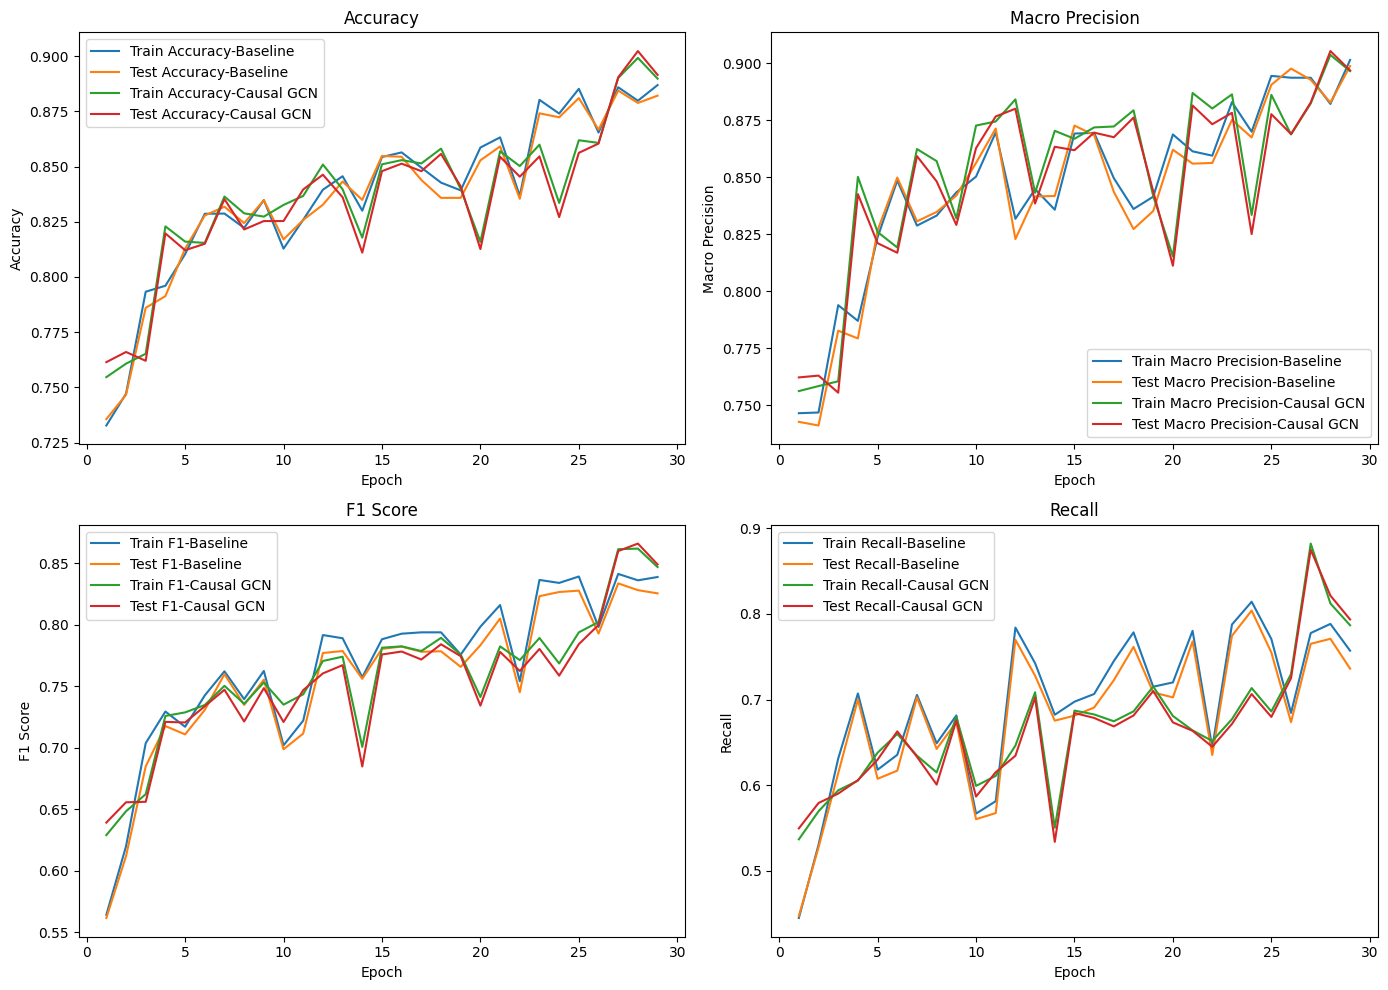

In [9]:
import matplotlib.pyplot as plt

# Data for each metric by epoch
epochs = range(1, 30)

#Base
train_accuracy_base = [0.7327, 0.7471, 0.7933, 0.7960, 0.8103, 0.8286, 0.8287, 0.8222, 0.8348, 0.8128, 0.8259, 0.8395, 0.8456, 0.8300, 0.8543, 0.8564, 0.8495, 0.8427, 0.8392, 0.8586, 0.8632, 0.8367, 0.8802, 0.8740, 0.8852, 0.8654, 0.8859, 0.8798, 0.8869]
test_accuracy_base = [0.7356, 0.7466, 0.7860, 0.7913, 0.8128, 0.8278, 0.8318, 0.8244, 0.8347, 0.8170, 0.8258, 0.8327, 0.8432, 0.8349, 0.8548, 0.8544, 0.8439, 0.8358, 0.8358, 0.8528, 0.8591, 0.8354, 0.8741, 0.8723, 0.8810, 0.8667, 0.8844, 0.8788, 0.8821]
train_precision_base = [0.7465, 0.7468, 0.7939, 0.7870, 0.8237, 0.8486, 0.8288, 0.8332, 0.8434, 0.8503, 0.8697, 0.8318, 0.8448, 0.8358, 0.8692, 0.8695, 0.8496, 0.8361, 0.8415, 0.8688, 0.8614, 0.8595, 0.8830, 0.8700, 0.8945, 0.8937, 0.8937, 0.8822, 0.9015]
test_precision_base = [0.7427, 0.7411, 0.7827, 0.7793, 0.8267, 0.8499, 0.8307, 0.8348, 0.8420, 0.8563, 0.8714, 0.8229, 0.8416, 0.8418, 0.8727, 0.8685, 0.8436, 0.8273, 0.8352, 0.8621, 0.8560, 0.8563, 0.8752, 0.8675, 0.8906, 0.8977, 0.8928, 0.8828, 0.8988]
train_f1_base = [0.5642, 0.6199, 0.7038, 0.7295, 0.7171, 0.7426, 0.7622, 0.7396, 0.7625, 0.7020, 0.7221, 0.7917, 0.7891, 0.7574, 0.7883, 0.7928, 0.7939, 0.7939, 0.7758, 0.7985, 0.8161, 0.7541, 0.8365, 0.8341, 0.8393, 0.7983, 0.8414, 0.8362, 0.8389]
test_f1_base = [0.5616, 0.6119, 0.6849, 0.7177, 0.7109, 0.7308, 0.7599, 0.7349, 0.7554, 0.6988, 0.7116, 0.7771, 0.7787, 0.7561, 0.7805, 0.7823, 0.7781, 0.7785, 0.7658, 0.7834, 0.8051, 0.7452, 0.8233, 0.8267, 0.8278, 0.7929, 0.8337, 0.8282, 0.8256]
train_recall_base = [0.4447, 0.5302, 0.6311, 0.7071, 0.6180, 0.6354, 0.7054, 0.6489, 0.6814, 0.5667, 0.5812, 0.7841, 0.7425, 0.6822, 0.6975, 0.7065, 0.7450, 0.7785, 0.7150, 0.7200, 0.7803, 0.6437, 0.7877, 0.8143, 0.7708, 0.6844, 0.7777, 0.7884, 0.7571]
test_recall_base = [0.4469, 0.5272, 0.6139, 0.7001, 0.6074, 0.6169, 0.7025, 0.6423, 0.6736, 0.5602, 0.5673, 0.7698, 0.7279, 0.6753, 0.6812, 0.6907, 0.7226, 0.7615, 0.7084, 0.7025, 0.7680, 0.6352, 0.7745, 0.8040, 0.7550, 0.6736, 0.7651, 0.7710, 0.7361]

#CGCN
train_accuracy_cgcn = [0.7546, 0.7607, 0.7652, 0.8229, 0.8160, 0.8154, 0.8364, 0.8288, 0.8273, 0.8326, 0.8367, 0.8509, 0.8397, 0.8178, 0.8510, 0.8529, 0.8514, 0.8581, 0.8398, 0.8159, 0.8569, 0.8502, 0.8599, 0.8335, 0.8619, 0.8607, 0.8901, 0.8992, 0.8898]
test_accuracy_cgcn = [0.7614, 0.7660, 0.7620, 0.8197, 0.8121, 0.8150, 0.8352, 0.8215, 0.8253, 0.8253, 0.8396, 0.8463, 0.8361, 0.8110, 0.8479, 0.8513, 0.8479, 0.8557, 0.8410, 0.8126, 0.8544, 0.8454, 0.8546, 0.8271, 0.8562, 0.8604, 0.8904, 0.9023, 0.8915]
train_precision_cgcn = [0.7562, 0.7584, 0.7605, 0.8502, 0.8260, 0.8192, 0.8624, 0.8571, 0.8320, 0.8727, 0.8745, 0.8842, 0.8432, 0.8704, 0.8669, 0.8719, 0.8723, 0.8794, 0.8418, 0.8153, 0.8870, 0.8802, 0.8864, 0.8335, 0.8862, 0.8688, 0.8824, 0.9037, 0.8966]
test_precision_cgcn = [0.7622, 0.7630, 0.7555, 0.8426, 0.8211, 0.8169, 0.8593, 0.8482, 0.8291, 0.8628, 0.8767, 0.8801, 0.8385, 0.8634, 0.8619, 0.8696, 0.8676, 0.8762, 0.8439, 0.8112, 0.8815, 0.8733, 0.8783, 0.8251, 0.8777, 0.8690, 0.8828, 0.9054, 0.8969]
train_f1_cgcn = [0.6290, 0.6484, 0.6623, 0.7259, 0.7288, 0.7348, 0.7504, 0.7358, 0.7531, 0.7351, 0.7435, 0.7706, 0.7741, 0.7007, 0.7814, 0.7825, 0.7787, 0.7894, 0.7758, 0.7413, 0.7825, 0.7713, 0.7893, 0.7686, 0.7939, 0.8023, 0.8615, 0.8620, 0.8470]
test_f1_cgcn = [0.6392, 0.6557, 0.6561, 0.7211, 0.7206, 0.7338, 0.7472, 0.7214, 0.7485, 0.7210, 0.7469, 0.7605, 0.7672, 0.6848, 0.7759, 0.7783, 0.7718, 0.7842, 0.7745, 0.7343, 0.7780, 0.7625, 0.7804, 0.7587, 0.7843, 0.7999, 0.8600, 0.8661, 0.8491]
train_recall_cgcn = [0.5366, 0.5694, 0.5939, 0.6052, 0.6379, 0.6598, 0.6344, 0.6148, 0.6796, 0.5991, 0.6108, 0.6461, 0.7085, 0.5502, 0.6871, 0.6826, 0.6746, 0.6862, 0.7152, 0.6808, 0.6639, 0.6516, 0.6771, 0.7134, 0.6861, 0.7297, 0.8823, 0.8123, 0.7868]
test_recall_cgcn = [0.5494, 0.5791, 0.5901, 0.6058, 0.6297, 0.6628, 0.6331, 0.6006, 0.6756, 0.5866, 0.6151, 0.6343, 0.7023, 0.5337, 0.6843, 0.6785, 0.6686, 0.6814, 0.7099, 0.6733, 0.6634, 0.6448, 0.6715, 0.7064, 0.6797, 0.7250, 0.8750, 0.8215, 0.7936]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

# Accuracy plot
axs[0].plot(epochs, train_accuracy_base, label='Train Accuracy-Baseline')
axs[0].plot(epochs, test_accuracy_base, label='Test Accuracy-Baseline')
axs[0].plot(epochs, train_accuracy_cgcn, label='Train Accuracy-Causal GCN')
axs[0].plot(epochs, test_accuracy_cgcn, label='Test Accuracy-Causal GCN')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Macro Precision plot
axs[1].plot(epochs, train_precision_base, label='Train Macro Precision-Baseline')
axs[1].plot(epochs, test_precision_base, label='Test Macro Precision-Baseline')
axs[1].plot(epochs, train_precision_cgcn, label='Train Macro Precision-Causal GCN')
axs[1].plot(epochs, test_precision_cgcn, label='Test Macro Precision-Causal GCN')
axs[1].set_title('Macro Precision')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Macro Precision')
axs[1].legend()

# F1 Score plot
axs[2].plot(epochs, train_f1_base, label='Train F1-Baseline')
axs[2].plot(epochs, test_f1_base, label='Test F1-Baseline')
axs[2].plot(epochs, train_f1_cgcn, label='Train F1-Causal GCN')
axs[2].plot(epochs, test_f1_cgcn, label='Test F1-Causal GCN')
axs[2].set_title('F1 Score')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('F1 Score')
axs[2].legend()

# Recall plot
axs[3].plot(epochs, train_recall_base, label='Train Recall-Baseline')
axs[3].plot(epochs, test_recall_base, label='Test Recall-Baseline')
axs[3].plot(epochs, train_recall_cgcn, label='Train Recall-Causal GCN')
axs[3].plot(epochs, test_recall_cgcn, label='Test Recall-Causal GCN')
axs[3].set_title('Recall')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Recall')
axs[3].legend()

plt.tight_layout()
plt.show()
